# **<font color='#7868e6'>Fake news detection</font>**

In this notebook, we are going to work on a dataset which consists of 3988 news articles. We will do some text processing and will build a deep learning model which will try to predict whether a particular news is fake or not. This is a Natural Language Processing problem, where we deal with text data and convert texts into some vectors it means a word will be defined as a vector. 


In [1]:
# libraries for data manipulation and exploration
import pandas as pd
import numpy as np

# for text processing
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# libraries for data visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [5]:
# reading the dataset
file_path = 'data.csv'
data = pd.read_csv(file_path)
data.head()

,URLs,Headline,Body,Label
0,http://www.bbc.com/news/world-us-canada-414191...,Four ways Bob Corker skewered Donald Trump,Image copyright Getty Images\nOn Sunday mornin...,1
1,https://www.reuters.com/article/us-filmfestiva...,Linklater's war veteran comedy speaks to moder...,"LONDON (Reuters) - “Last Flag Flying”, a comed...",1
2,https://www.nytimes.com/2017/10/09/us/politics...,Trump’s Fight With Corker Jeopardizes His Legi...,The feud broke into public view last week when...,1
3,https://www.reuters.com/article/us-mexico-oil-...,Egypt's Cheiron wins tie-up with Pemex for Mex...,MEXICO CITY (Reuters) - Egypt’s Cheiron Holdin...,1
4,http://www.cnn.com/videos/cnnmoney/2017/10/08/...,Jason Aldean opens 'SNL' with Vegas tribute,"Country singer Jason Aldean, who was performin...",1


In [6]:
# checking the dimension of dataset
data.shape

(4009, 4)

### **<font color='#7868e6'>Data description</font>**
This dataset contains 4009 rows and 4 columns, here we will see the what each column describe.
- `URLs` : URL of the news
- `Headline` : Headline of the news
- `Body` : News description
- `Label` : **0** for fake news and **1** for true news

In [7]:
# checking if there is any null value
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4009 entries, 0 to 4008
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   URLs      4009 non-null   object
 1   Headline  4009 non-null   object
 2   Body      3988 non-null   object
 3   Label     4009 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 125.4+ KB


There are few null values in `Body` and `Website` columns, so we can remove those rows because we are dropping only 21 rows, and not loosing much information.

### **<font color='#7868e6'> Sentiment Analysis</font>**

In [ ]:
### **<font color='#7868e6'>Analysis</font>**

In [8]:
# dropping rows where there is any null value
data.dropna(inplace=True, axis=0)

# taking only the name of website from the URLs
pattern = 'https?://([\w.]+)/'
data['Website'] = data.URLs.str.extract(pattern)
data.drop('URLs', axis=1, inplace=True)

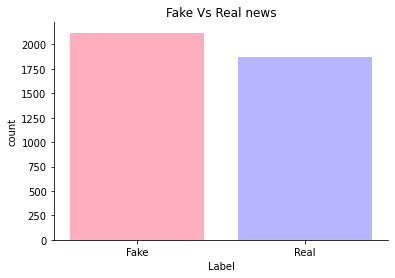

In [9]:
# making a bar plot to count the frequency of 
# fake and real news
sns.countplot(x='Label', 
              data=data,
              palette=['#ffaec0', '#b8b5ff'],
              saturation=1)
sns.despine()
plt.xticks([0,1], ['Fake', 'Real'])
plt.title('Fake Vs Real news');

In our dataset, we have more number of fake news as compare to real news. However, there is no huge difference in the ratio so the dataset is somewhat unbalanced and it is fine. 

We can start working on it.

Let's see which websites contain more number of real or fake news.

In [10]:
fake_news_count = data[data.Label == 0]['Website'].value_counts()
real_news_count = data[data.Label == 1]['Website'].value_counts()

In [11]:
fdf = pd.DataFrame({
    'Web':fake_news_count.index,
    'Fake':fake_news_count.values
})

rdf = pd.DataFrame({
    'Web':real_news_count.index,
    'Real':real_news_count.values
})

In [12]:
rf_count = pd.merge(rdf, fdf, on='Web', how='outer').fillna(0)
rf_count['Real'] = rf_count['Real'].astype(int)
rf_count['Fake'] = rf_count['Fake'].astype(int)
rf_count

,Web,Real,Fake
0,www.reuters.com,646,0
1,www.cnn.com,389,0
2,www.nytimes.com,341,0
3,www.bbc.com,333,0
4,abcnews.go.com,57,0
5,money.cnn.com,49,0
6,edition.cnn.com,15,0
7,inhealth.cnn.com,14,0
8,www.bbc.co.uk,10,0
9,bleacherreport.com,8,0


Now, we observed that websites are only posting either fake news or real news but not both of them means one website is only posting one type of news either fake or real but not both. 

Most of the websites are posting real news, only four websites are there posting fake news.

So, we want to see the following:
- Top 5 websites posting real news
- Top 5 websites posting fake news

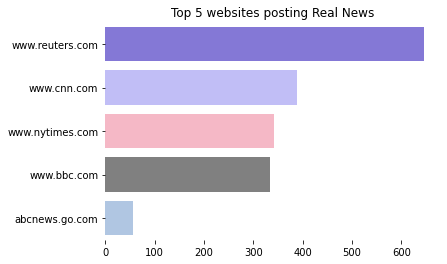

In [13]:
sns.barplot(y=real_news_count[:5].index, x=real_news_count[:5].values, 
            palette=['#7868e6', '#b8b5ff', '#ffaec0', 'grey', '#a7c5eb'])
sns.despine(bottom=True, left=True)
plt.title('Top 5 websites posting Real News');

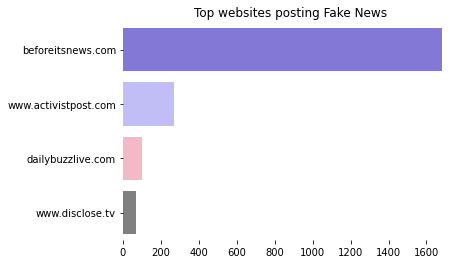

In [14]:
sns.barplot(y=fake_news_count.index, x=fake_news_count.values,
            palette=['#7868e6', '#b8b5ff', '#ffaec0', 'grey'])
sns.despine(bottom=True, left=True)
plt.title('Top websites posting Fake News');

### **<font color='#7868e6'>Text cleaning</font>**
Here, we will remove the unwanted words such as puntuation marks and stop words like - the, is, there, his etc. beacause these words are more frequent and don't have much importance. So, by removing these words we will get important words which will help us to find patterns regarding fake and real news.

 **Steps for text cleaning :**
- convert each word to lower case
- remove any words apart from alphabets
- remove stop words


In [15]:
lm = WordNetLemmatizer()
def clean_text(column):
    corpus = []
    for value in column:
        # convert each word into lower case
        value = value.lower()
        # take only alphabets
        value = re.sub('[^a-z]', ' ', value)
        value = value.split()
        # lemmatizing those words which are not stop words
        value = [lm.lemmatize(word) for word in value\
                 if word not in set(stopwords.words('english'))]
        corpus.append(' '.join(value))
    return corpus    

# taking both headline and body of news into a single column
data['Text'] = data['Headline'] + ' ' + data['Body']
data['Text'] = clean_text(data.Text)

LookupError: 
**********************************************************************
  Resource [93mstopwords[0m not found.
  Please use the NLTK Downloader to obtain the resource:

  [31m>>> import nltk
  >>> nltk.download('stopwords')
  [0m
  For more information see: https://www.nltk.org/data.html

  Attempted to load [93mcorpora/stopwords[0m

  Searched in:
    - 'C:\\Users\\ayush/nltk_data'
    - 'c:\\users\\ayush\\appdata\\local\\programs\\python\\python39\\nltk_data'
    - 'c:\\users\\ayush\\appdata\\local\\programs\\python\\python39\\share\\nltk_data'
    - 'c:\\users\\ayush\\appdata\\local\\programs\\python\\python39\\lib\\nltk_data'
    - 'C:\\Users\\ayush\\AppData\\Roaming\\nltk_data'
    - 'C:\\nltk_data'
    - 'D:\\nltk_data'
    - 'E:\\nltk_data'
**********************************************************************


After cleaning we will try to know about the most frequent words come in real and fake news. To get this thing done, we can use a cloud of words which shows words frequency on the basis of their size means words with bigger fontsize appear mostly as compare to other.

We have combined both **Headline** and **Body** column.

In [16]:
from wordcloud import WordCloud, STOPWORDS
sw = set(STOPWORDS)

fake_news = data[data.Label == 0]
real_news = data[data.Label == 1]

# wordcloud for fake news
fake_wc = WordCloud(width = 1200, height = 600, 
                    background_color ='white', 
                    stopwords = sw, 
                    min_font_size = 10).generate(' '.join(fake_news.Text)) 
  
# plot the WordCloud image                        
plt.figure(figsize = (12, 6), facecolor = None) 
plt.imshow(fake_wc) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.title('Word Cloud for fake news', fontsize=20);

ModuleNotFoundError: No module named 'wordcloud'

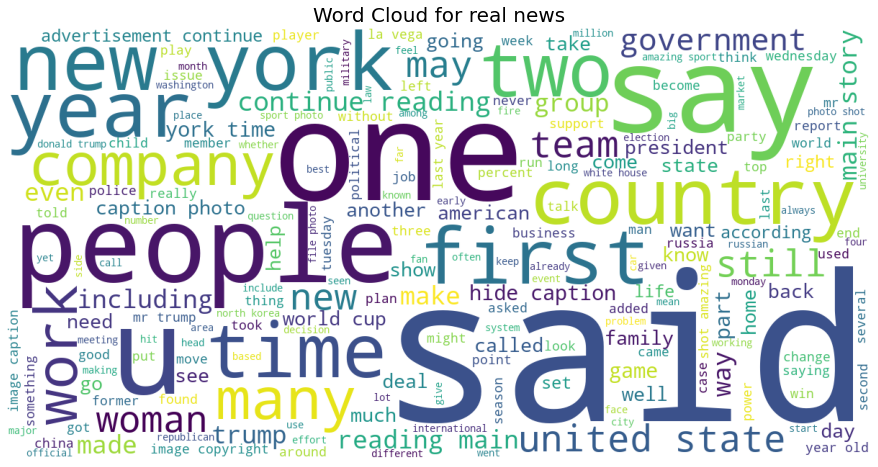

In [14]:
# wordcloud for real news
real_wc = WordCloud(width = 1200, height = 600, 
                    background_color ='white', 
                    stopwords = sw, 
                    min_font_size = 10).generate(' '.join(real_news.Text)) 
  
# plot the WordCloud image                        
plt.figure(figsize = (12, 6), facecolor = None) 
plt.imshow(real_wc) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.title('Word Cloud for real news', fontsize=20);

### **<font color='#7868e6'>Modeling</font>**
Here, we are going to build a deep learning model.

In [15]:
from tensorflow.keras.layers import Embedding
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.layers import LSTM, Dense

In [16]:
# one hot representation of words
oh_repr = [one_hot(words, 5000) for words in data.Text]

In [17]:
# list to store length of words in each news
len_list = []
for w in data.Text:
    w = w.split()
    len_list.append(len(w))

print('Summary of word length :')
pd.Series(len_list).describe()

Summary of word length :


count    3988.000000
mean      289.271063
std       289.423529
min        10.000000
25%        65.000000
50%       217.000000
75%       419.000000
max      3171.000000
dtype: float64

In [18]:
# taking sentences length as 400
sent_length = 400
# padding
embedded_doc = pad_sequences(oh_repr, padding='pre', maxlen=sent_length)
embedded_doc[:5]

array([[1370, 4751, 1051, ..., 3636,  712, 2130],
       [   0,    0,    0, ..., 2569, 1868, 4970],
       [2389,  314,  355, ..., 4828,  711,  760],
       [   0,    0,    0, ..., 2457, 3870, 3945],
       [   0,    0,    0, ..., 2183, 2051, 4523]], dtype=int32)

In [19]:
# initializing model
model = Sequential()
# adding embedding layer
model.add(Embedding(5000, 100, input_length=sent_length))
model.add(LSTM(150))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 400, 100)          500000    
_________________________________________________________________
lstm (LSTM)                  (None, 150)               150600    
_________________________________________________________________
dense (Dense)                (None, 1)                 151       
Total params: 650,751
Trainable params: 650,751
Non-trainable params: 0
_________________________________________________________________


In [20]:
from sklearn.model_selection import train_test_split
x = np.array(embedded_doc)
y = data.Label

# splitting the dataset into train and test
train_x, test_x, train_y, test_y = train_test_split(x, y, 
                                                    test_size=0.25, random_state=3)

In [21]:
# fitting the model
history = model.fit(train_x, train_y, validation_data=(test_x, test_y), epochs=10, batch_size=64)

Epoch 1/10
47/47 [==============================] - 38s 757ms/step - loss: 0.6233 - accuracy: 0.6694 - val_loss: 0.2089 - val_accuracy: 0.9368
Epoch 2/10
47/47 [==============================] - 34s 725ms/step - loss: 0.1262 - accuracy: 0.9599 - val_loss: 0.0856 - val_accuracy: 0.9699
Epoch 3/10
47/47 [==============================] - 34s 735ms/step - loss: 0.0190 - accuracy: 0.9965 - val_loss: 0.0831 - val_accuracy: 0.9709
Epoch 4/10
47/47 [==============================] - 34s 734ms/step - loss: 0.0095 - accuracy: 0.9990 - val_loss: 0.0752 - val_accuracy: 0.9769
Epoch 5/10
47/47 [==============================] - 34s 729ms/step - loss: 0.0037 - accuracy: 0.9996 - val_loss: 0.0876 - val_accuracy: 0.9769
Epoch 6/10
47/47 [==============================] - 34s 730ms/step - loss: 9.0560e-04 - accuracy: 1.0000 - val_loss: 0.0964 - val_accuracy: 0.9779
Epoch 7/10
47/47 [==============================] - 34s 731ms/step - loss: 5.3566e-04 - accuracy: 1.0000 - val_loss: 0.1029 - val_accuracy

In [22]:
from sklearn.metrics import confusion_matrix, accuracy_score
pred = model.predict_classes(test_x);

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


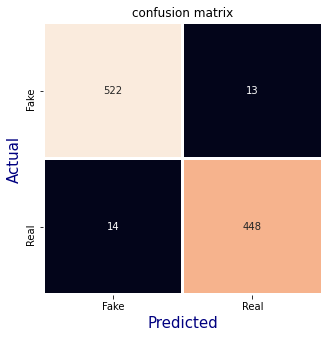

In [23]:
# plotting graph for confusion matrix
cm = confusion_matrix(test_y, pred)
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt='', cbar=False, linewidths=2,
            xticklabels = ['Fake','Real'], yticklabels = ['Fake','Real'])
plt.title('confusion matrix')
plt.xlabel('Predicted', color='navy', fontsize=15)
plt.ylabel('Actual', color='navy', fontsize=15);

In [24]:
# accuracy of the model we built
accuracy_score(test_y, pred)

0.9729187562688064

So, we built a LSTM model with 97% accuracy which is quit amazing. We can try other parameters in order to increase the accuracy.